<a href="https://colab.research.google.com/github/LeylaY1996/sentiment-analysis-aws-reviews/blob/main/sentiment-analysis-rearrange-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Veri setini yükle
csv_file_path = '/content/Reviews.csv'  # Dosya yolunuza göre güncelleyin
df = pd.read_csv(csv_file_path, on_bad_lines='skip',quoting=3)  # daha yeni versiyonlar için
# Veri setinin boyutunu yazdır
print("Orijinal veri seti boyutu:", df.shape)

# %20 oranında rastgele bir alt küme seç
sampled_df = df.sample(frac=0.2, random_state=42)  # random_state ile tekrarlanabilirlik sağlar

# Yeni veri setinin boyutunu yazdır
print("Yeni veri seti boyutu:", sampled_df.shape)

# İstediğiniz gibi veriyi kaydedin veya kullanın
sampled_df.to_csv('sampled_reviews.csv', index=False)  # Yeni dosyayı kaydet

Orijinal veri seti boyutu: (3414, 10)
Yeni veri seti boyutu: (683, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


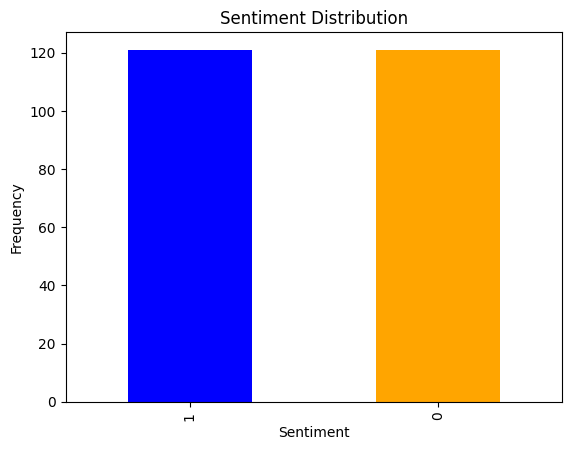

Ortalama Yorum Uzunluğu: 140.94628099173553
Standart Sapma: 94.14543136829516
Aykırı değerler çıkarıldıktan sonra veri seti boyutu: (236, 2)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from scipy import stats

# NLTK stopwords yükle
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def clean_text(text):
    """Metni temizler: küçük harfe çevirir, noktalama işaretlerini kaldırır ve durak kelimeleri filtreler."""
    text = text.lower()  # Küçük harfe çevir
    text = ''.join([char for char in text if char not in punctuation])  # Noktalama işaretlerini kaldır
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Durak kelimeleri filtrele
    return text

def prepare_data(csv_file):
    """Veri setini hazırlar: yükler, temizler ve etiketler."""

    # Veri setini yükle
    df = pd.read_csv(csv_file)

    # Gerekli sütunları seçin
    df = df[['Text', 'Score']]

    # Skorları ikili hale getirin (örneğin: 1-3 olumsuz, 4-5 olumlu)
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

    # Yorumları temizle
    df['cleaned_review'] = df['Text'].apply(clean_text)

    # Sadece temizlenmiş yorumlar ve duygu etiketlerini içeren DataFrame döndür
    return df[['cleaned_review', 'Sentiment']]

# Veriyi yükle ve hazırla
csv_file_path = '/content/sampled_reviews.csv'  # Dosya yolunuza göre güncelleyin
prepared_data = prepare_data(csv_file_path)

# Veri dengesini sağlama
# Olumlu ve olumsuz örneklerin sayısını bul
positive_samples = prepared_data[prepared_data['Sentiment'] == 1]
negative_samples = prepared_data[prepared_data['Sentiment'] == 0]

# Minimum sayıda olan sınıfa göre dengeleme
min_samples = min(len(positive_samples), len(negative_samples))
balanced_data = pd.concat([positive_samples.sample(min_samples, random_state=42),
                           negative_samples.sample(min_samples, random_state=42)])

# Histogram çizme
balanced_data['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# Ortalama ve standart sapma hesaplama
mean_length = balanced_data['cleaned_review'].apply(len).mean()
std_length = balanced_data['cleaned_review'].apply(len).std()
print(f"Ortalama Yorum Uzunluğu: {mean_length}")
print(f"Standart Sapma: {std_length}")

# Aykırı değer kontrolü (örneğin, yorum uzunluğuna göre aykırı değer)
z_scores = np.abs(stats.zscore(balanced_data['cleaned_review'].apply(len)))
balanced_data = balanced_data[(z_scores < 3)]

print("Aykırı değerler çıkarıldıktan sonra veri seti boyutu:", balanced_data.shape)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def svm_sentiment_analysis(df):
    """Verilen veri setinde SVM ile duygu analizi yapar ve sonuçları döner."""

    # Veriyi eğitim ve test setine ayır
    X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['Sentiment'], test_size=0.2, random_state=42)

    # TF-IDF vektörleştirme
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # SVM modelini oluştur ve eğit
    model = SVC(kernel='linear')
    model.fit(X_train_tfidf, y_train)

    # Tahmin yap
    y_pred = model.predict(X_test_tfidf)

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Karmaşıklık matrisi
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

# SVM analizi
accuracy, report, cm = svm_sentiment_analysis(prepared_data)

print("Accuracy:", accuracy)
print(report)
print("Confusion Matrix:\n", cm)

Accuracy: 0.8467153284671532
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        22
           1       0.85      1.00      0.92       115

    accuracy                           0.85       137
   macro avg       0.92      0.52      0.50       137
weighted avg       0.87      0.85      0.78       137

Confusion Matrix:
 [[  1  21]
 [  0 115]]


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def naive_bayes_sentiment_analysis(df):
    """Verilen veri setinde Naive Bayes ile duygu analizi yapar ve sonuçları döner."""

    # Veriyi eğitim ve test setine ayır
    X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['Sentiment'], test_size=0.2, random_state=42)

    # TF-IDF vektörleştirme
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Naive Bayes modelini oluştur ve eğit
    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)

    # Tahmin yap
    y_pred = model.predict(X_test_tfidf)

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)

    # Karmaşıklık matrisi
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

# Naive Bayes analizi
accuracy, report, cm = naive_bayes_sentiment_analysis(prepared_data)

print("Accuracy:", accuracy)
print(report)
print("Confusion Matrix:\n", cm)

Accuracy: 0.8394160583941606
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       0.84      1.00      0.91       115

    accuracy                           0.84       137
   macro avg       0.92      0.50      0.46       137
weighted avg       0.87      0.84      0.77       137

Confusion Matrix:
 [[  0  22]
 [  0 115]]


In [7]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# RNN model fonksiyonu
def rnn_sentiment_analysis(df):
    """Verilen veri setinde RNN (LSTM) ile duygu analizi yapar ve sonuçları döner."""

    # Etiketleri sayısal değerlere dönüştür
    label_encoder = LabelEncoder()
    df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

    # Veriyi eğitim ve test setine ayır
    X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['Sentiment'], test_size=0.2, random_state=42)

    # Metni sayısal verilere dönüştür
    vectorizer = TfidfVectorizer(max_features=5000)  # max_features ile öznitelik sayısını sınırlayın
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()

    # RNN için veriyi uygun biçime getirin
    max_length = 100  # Maximum uzunluk
    X_train_padded = pad_sequences(X_train_tfidf, maxlen=max_length)
    X_test_padded = pad_sequences(X_test_tfidf, maxlen=max_length)

    # Modeli oluştur
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128))  # input_length kaldırıldı
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Modeli derle
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Modeli eğit
    model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

    # Test verisi üzerinde tahmin yap
    y_pred = (model.predict(X_test_padded) > 0.5).astype("int32").flatten()

    # Sonuçları değerlendir
    accuracy = np.mean(y_pred == y_test)
    report = classification_report(y_test, y_pred, zero_division=1)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

# RNN analizi
accuracy, report, cm = rnn_sentiment_analysis(prepared_data)
print("Accuracy:", accuracy)
print(report)
print("Confusion Matrix:\n", cm)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - accuracy: 0.7295 - loss: 0.5969 - val_accuracy: 0.8394 - val_loss: 0.4444
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.8142 - loss: 0.4995 - val_accuracy: 0.8394 - val_loss: 0.4496
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.8151 - loss: 0.4791 - val_accuracy: 0.8394 - val_loss: 0.4406
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.8220 - loss: 0.4711 - val_accuracy: 0.8394 - val_loss: 0.4458
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.8093 - loss: 0.4860 - val_accuracy: 0.8394 - val_loss: 0.4410
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.8394160583941606
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       0.84      1.00      0.91       115

    accuracy                           0.84       137
   macro avg       0.92      0.50      0.46       137
weighted avg       0.87      0.84   

In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Örnek bir duygu sözlüğü
positive_words = {'good', 'great', 'excellent', 'happy', 'love', 'wonderful', 'amazing', 'fantastic'}
negative_words = {'bad', 'terrible', 'horrible', 'sad', 'hate', 'awful', 'disappointing', 'poor'}

def lexicon_based_sentiment_analysis(df):
    """Verilen veri setinde lexicon-based duygu analizi yapar."""

    def get_sentiment(text):
        """Metindeki kelimeleri analiz ederek duygu puanı döndürür."""
        words = text.split()
        score = 0

        for word in words:
            if word in positive_words:
                score += 1  # Pozitif kelime varsa puanı artır
            elif word in negative_words:
                score -= 1  # Negatif kelime varsa puanı azalt

        return 1 if score > 0 else 0  # Pozitif ise 1, olumsuz ise 0 döndür

    # Her bir yorum için duygu analizi yap
    df['Lexicon_Sentiment'] = df['cleaned_review'].apply(get_sentiment)

    # Doğruluğu hesapla
    accuracy = accuracy_score(df['Sentiment'], df['Lexicon_Sentiment'])

    # Sınıflandırma raporu ve karmaşıklık matrisi
    report = classification_report(df['Sentiment'], df['Lexicon_Sentiment'])
    cm = confusion_matrix(df['Sentiment'], df['Lexicon_Sentiment'])

    return df[['cleaned_review', 'Sentiment', 'Lexicon_Sentiment']], accuracy, report, cm

# Lexicon-based analizi
lexicon_results, lexicon_accuracy, lexicon_report, lexicon_cm = lexicon_based_sentiment_analysis(prepared_data)

# Sonuçları yazdır
print("Lexicon-Based Accuracy:", lexicon_accuracy)
print(lexicon_report)
print("Confusion Matrix:\n", lexicon_cm)
print(lexicon_results.head())

Lexicon-Based Accuracy: 0.6734992679355783
              precision    recall  f1-score   support

           0       0.33      0.79      0.46       121
           1       0.94      0.65      0.77       562

    accuracy                           0.67       683
   macro avg       0.63      0.72      0.61       683
weighted avg       0.83      0.67      0.71       683

Confusion Matrix:
 [[ 96  25]
 [198 364]]
                                      cleaned_review  Sentiment  \
0  love ahmad tea earl grey wonderful tea afterno...          1   
1  package arrived 3 days earlier said would fres...          0   
2  dinner friends family saloon rte 46 entertainm...          1   
3  serious cup joe yummynessbr turned least 3 fri...          1   
4            enjoy treat low carb diet nice chip dip          1   

   Lexicon_Sentiment  
0                  1  
1                  1  
2                  0  
3                  0  
4                  0  


In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Örnek bir özellik ve ona bağlı duygu sözlüğü
aspects = {
    'hız': {'good', 'great', 'fast', 'quick', 'excellent', 'amazing', 'slow', 'not fast'},
    'kalite': {'bad', 'poor', 'terrible', 'awful', 'good', 'excellent', 'not good'}
}

def aspect_based_sentiment_analysis(df):
    """Verilen veri setinde aspect-based duygu analizi yapar."""

    def get_aspect_sentiment(text):
        """Metindeki her bir özellik için duygu puanı döndürür."""
        words = text.split()
        aspect_scores = {aspect: 0 for aspect in aspects.keys()}

        for word in words:
            for aspect, keywords in aspects.items():
                if word in keywords:
                    # Pozitif kelime için puanı artır
                    aspect_scores[aspect] += 1 if 'not' not in word else -1

        # Her bir bileşen için 1 (olumlu) veya 0 (olumsuz) döndür
        return int(aspect_scores['hız'] > 0), int(aspect_scores['kalite'] > 0)

    # Her bir yorum için aspect-based duygu analizi yap
    df[['Aspect_Hız', 'Aspect_Kalite']] = df['cleaned_review'].apply(get_aspect_sentiment).apply(pd.Series)

    # Doğruluk hesapla
    accuracy_hız = accuracy_score(df['Sentiment'], df['Aspect_Hız'])
    accuracy_kalite = accuracy_score(df['Sentiment'], df['Aspect_Kalite'])

    # Sınıflandırma raporu ve karmaşıklık matrisleri
    report_hız = classification_report(df['Sentiment'], df['Aspect_Hız'])
    cm_hız = confusion_matrix(df['Sentiment'], df['Aspect_Hız'])

    report_kalite = classification_report(df['Sentiment'], df['Aspect_Kalite'])
    cm_kalite = confusion_matrix(df['Sentiment'], df['Aspect_Kalite'])

    return df[['cleaned_review', 'Sentiment', 'Aspect_Hız', 'Aspect_Kalite']], accuracy_hız, accuracy_kalite, report_hız, report_kalite, cm_hız, cm_kalite

# Aspect-based analizi
aspect_results, aspect_accuracy_hız, aspect_accuracy_kalite, report_hız, report_kalite, cm_hız, cm_kalite = aspect_based_sentiment_analysis(prepared_data)

# Sonuçları yazdır
print("Aspect-Based Accuracy (Hız):", aspect_accuracy_hız)
print(report_hız)
print("Confusion Matrix (Hız):\n", cm_hız)

print("Aspect-Based Accuracy (Kalite):", aspect_accuracy_kalite)
print(report_kalite)
print("Confusion Matrix (Kalite):\n", cm_kalite)

print(aspect_results.head())

Aspect-Based Accuracy (Hız): 0.5651537335285505
              precision    recall  f1-score   support

           0       0.26      0.76      0.38       121
           1       0.91      0.52      0.66       562

    accuracy                           0.57       683
   macro avg       0.58      0.64      0.52       683
weighted avg       0.79      0.57      0.61       683

Confusion Matrix (Hız):
 [[ 92  29]
 [268 294]]
Aspect-Based Accuracy (Kalite): 0.36749633967789164
              precision    recall  f1-score   support

           0       0.18      0.74      0.29       121
           1       0.84      0.29      0.43       562

    accuracy                           0.37       683
   macro avg       0.51      0.51      0.36       683
weighted avg       0.72      0.37      0.40       683

Confusion Matrix (Kalite):
 [[ 89  32]
 [400 162]]
                                      cleaned_review  Sentiment  Aspect_Hız  \
0  love ahmad tea earl grey wonderful tea afterno...          1     